get high-weighting bands

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
import pickle
import numpy as np
import pandas as pd
from pymongo import MongoClient

import seaborn as sns
import matplotlib.pyplot as plt

import smote_variants as sv
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import StratifiedShuffleSplit

from utils import *

In [8]:
matfile = '../../data/all_bands_weight.pkl'
labelfile = '../../data/all_bands_label.pkl'
dlabelfile = '../../data/all_bands_disease_label.pkl'
bandfile = '../../data/bands.pkl'
slabelfile = '../../data/all_bands_subtype_label.pkl'
featfile = '../../data/all_bands.pkl'

with open(matfile, 'rb') as fmat, open(labelfile, 'rb') as flab, open(bandfile, 'rb') as fbd, open(dlabelfile, 'rb') as fdl, open(slabelfile, 'rb') as fsl, open(featfile, 'rb') as ff:
    data = pickle.load(fmat)
    labels = pickle.load(flab)
    bands = pickle.load(fbd)
    disease_labels = pickle.load(fdl)
    subtypes = pickle.load(fsl)
    fm = pickle.load(ff)
    
genefile =  '../../data/genes.tsv'
genes = pd.read_csv(genefile, sep='\t', names=['gene_id', 'name', 'chr','start','end', 'symbol'], header=0)
postive_data = np.maximum(data, 0)


## Test distribution of values

### using direct codes

Disease name from codes

In [20]:
codes, counts = np.unique(disease_labels, return_counts=True)
df = pd.DataFrame({'code':codes,'count':counts}).sort_values('count', ascending=False)

df = df[(df['count']>50) & (-df['code'].isin(['Others', 'None']))]

disease_names = df.code.tolist()

Check the value distribution of each label

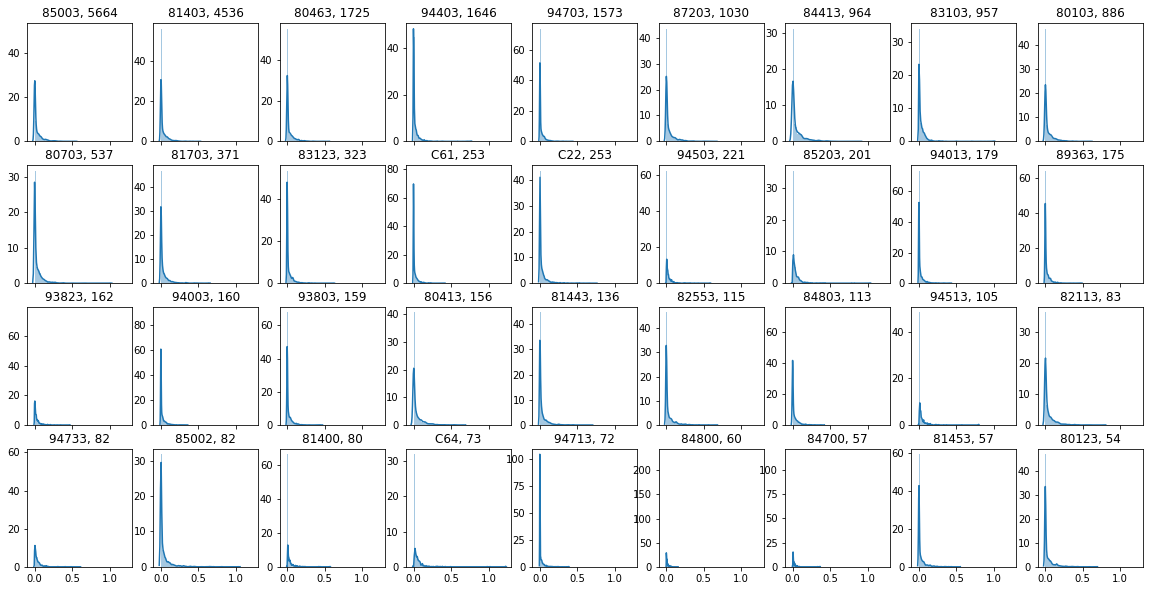

In [58]:
high_impact_bands = [False] * 1622

sig_thresh = 0.2
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[disease_labels == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}, {}'.format(dname, int(df.loc[df.code == dname  , 'count'])))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1
    
    high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

### Using merged subtype names

Disease names from curation

In [77]:
disease_names = list(np.unique(subtypes['disease']))

disease_names.remove('NA')

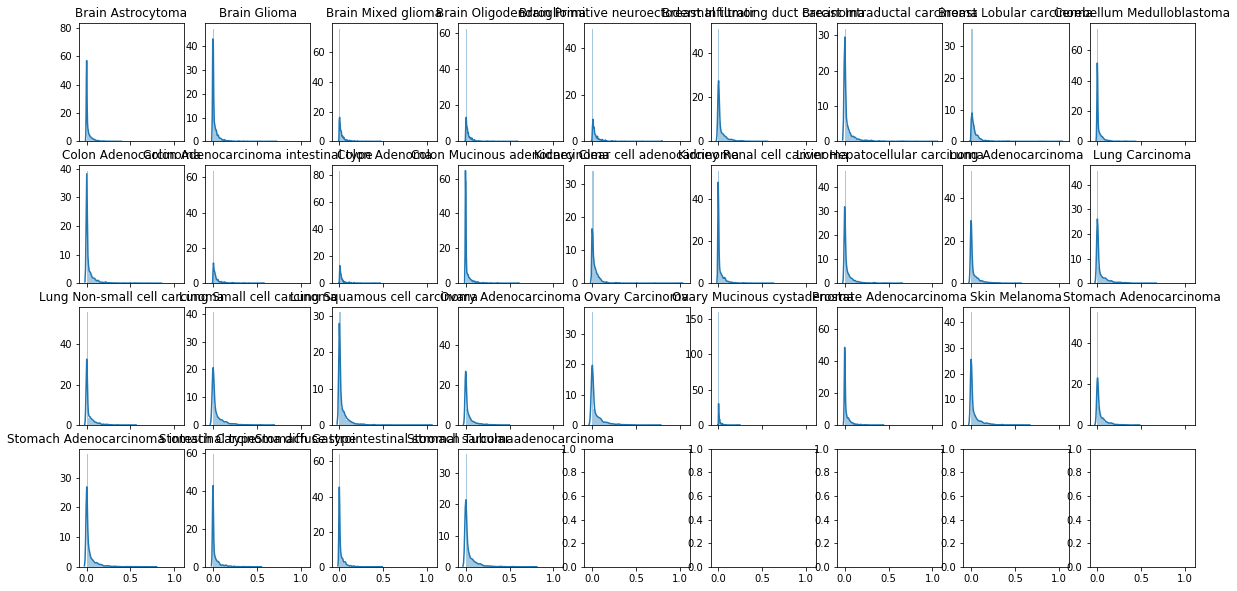

In [83]:
high_impact_bands = [False] * 1622

sig_thresh = 0.2
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[subtypes['disease'] == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}'.format(dname))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1
    
    high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

## concept testing

In [11]:
disease_names = list(np.unique(subtypes['disease']))
disease_names.remove('NA')

In [18]:
all_results = []
all_high_filters = []

In [ ]:
for sig_thresh in np.arange(0, 0.32, 0.02):

    
    # find high impact bands
    high_impact_bands = [False] * 1622

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
    names = names.rename(columns={0:'disease',1:'count'})
    names = names[names['disease'] != 'NA']
    names = names.reset_index(drop=True)
    names['target'] = names.index 
    names = names[['disease', 'target']]

    dlt = pd.merge(subtypes, names, how='left', on='disease')

    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
    t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
    n = names['disease'].to_numpy()

    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))
    
    all_results.append(result)
    all_high_filters.append(high_impact_bands)

In [37]:
mtr = [[],[],[],[],[]]

for r,f in zip(all_results, all_high_filters):
    r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 0.32, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.00,0.611398,0.493815,0.474734,0.472964,1543
1,0.02,0.617631,0.503137,0.460399,0.469349,957
2,0.04,0.609439,0.490198,0.473216,0.471062,721
3,0.06,0.609083,0.505367,0.473661,0.476577,630
4,0.08,0.601603,0.490144,0.466348,0.463042,533
5,0.10,0.595726,0.471752,0.457028,0.456069,470
6,0.12,0.608014,0.481397,0.443395,0.449770,413
7,0.14,0.587533,0.440559,0.440108,0.431926,350
8,0.16,0.586999,0.443985,0.439814,0.430252,310
9,0.18,0.587177,0.442382,0.440273,0.432869,266


In [58]:
for r, t in zip(all_results, np.arange(0, 0.32, 0.02)):
    
    r = r[0]
    if t == 0:
        classes = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        classes = classes[['Label','F1-score']]
        classes = classes.rename(columns = {'F1-score':str(t)})
    else:
        c = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        c = c[['Label','F1-score']]
        c = c.rename(columns = {'F1-score':str(t)})

        classes = pd.merge(classes, c, how='left', on='Label')

classes


,Label,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3
0,Brain Astrocytoma,0.295567,0.315789,0.313514,0.337349,0.295858,0.340659,0.335135,0.330097,0.274725,0.279570,0.220690,0.283105,0.334928,0.297030,0.278351,0.233645
1,Brain Glioma,0.715477,0.726606,0.710714,0.710909,0.717117,0.716228,0.740608,0.731490,0.709562,0.710403,0.715789,0.725044,0.687500,0.689165,0.688057,0.664855
2,Brain Mixed glioma,0.256410,0.326531,0.282051,0.247423,0.180000,0.177778,0.244444,0.177215,0.242991,0.195652,0.318584,0.250000,0.231579,0.127660,0.229885,0.250000
3,Brain Oligodendroglioma,0.412214,0.372093,0.457143,0.466165,0.376812,0.517986,0.484848,0.421053,0.435484,0.431655,0.496000,0.483871,0.432000,0.394161,0.387597,0.451613
4,Brain Primitive neuroectodermal tumor,0.244898,0.142857,0.130435,0.333333,0.225806,0.285714,0.295082,0.233333,0.235294,0.218750,0.266667,0.235294,0.246154,0.190476,0.210526,0.269231
5,Breast Infiltrating duct carcinoma,0.595163,0.590131,0.580376,0.578947,0.570010,0.565032,0.578288,0.524313,0.546793,0.510730,0.540373,0.519737,0.562780,0.527897,0.529349,0.543502
6,Breast Intraductal carcinoma,0.680000,0.666667,0.851852,0.692308,0.734694,0.653846,0.680851,0.745098,0.571429,0.600000,0.523810,0.622951,0.680000,0.500000,0.760000,0.745098
7,Breast Lobular carcinoma,0.657343,0.650794,0.609375,0.537313,0.535433,0.552846,0.598425,0.586667,0.489209,0.578947,0.619718,0.579310,0.463415,0.517483,0.503145,0.471429
8,Cerebellum Medulloblastoma,0.713568,0.716724,0.716918,0.693844,0.708714,0.678718,0.699588,0.696246,0.694915,0.693467,0.681704,0.693739,0.678421,0.691126,0.690355,0.679934
9,Colon Adenocarcinoma,0.703879,0.720737,0.719855,0.677333,0.695733,0.693989,0.703802,0.705775,0.704995,0.701657,0.682439,0.689030,0.689152,0.672300,0.696143,0.697111


## 3-fold evaluation

prepare labels

In [59]:
names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
names = names.rename(columns={0:'disease',1:'count'})
names = names[names['disease'] != 'NA']
names = names.reset_index(drop=True)
names['target'] = names.index 
names = names[['disease', 'target']]

dlt = pd.merge(subtypes, names, how='left', on='disease')

l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
n = names['disease'].to_numpy()

In [ ]:
all_results_3 = []
all_high_filters_3 = []

for sig_thresh in np.arange(0, 0.32, 0.02):

    
    # find high impact bands
    high_impact_bands = [False] * 1622

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=3, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))

    all_results_3.append(result)
    all_high_filters_3.append(high_impact_bands)

In [68]:
mtr = [[],[],[],[],[]]
n = 3
for res,f in zip(all_results_3, all_high_filters_3):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    

    
pd.DataFrame({'thresh': np.arange(0, 0.32, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})
    



,thresh,accuracy,precision,recall,f1,features
0,0.00,0.622321,0.511057,0.476655,0.483873,1543
1,0.02,0.615138,0.512534,0.469903,0.475891,957
2,0.04,0.605343,0.480725,0.456426,0.456530,721
3,0.06,0.609914,0.469939,0.451480,0.449884,630
4,0.08,0.598397,0.470169,0.450386,0.449420,533
5,0.10,0.597744,0.468398,0.446481,0.445465,470
6,0.12,0.605996,0.472816,0.452545,0.452792,413
7,0.14,0.595548,0.456685,0.437459,0.436685,350
8,0.16,0.589789,0.451644,0.438998,0.435460,310
9,0.18,0.589908,0.442874,0.442588,0.433452,266


## Final  grid search

In [70]:
np.arange(0, 0.08, 0.005).shape

(16,)

In [71]:
np.arange(0, 0.32, 0.02).shape

(16,)

In [ ]:
all_results_best = []
all_high_filters_best = []

for sig_thresh in np.arange(0, 0.08, 0.005):

    
    # find high impact bands
    high_impact_bands = [False] * 1622

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))

    all_results_best.append(result)
    all_high_filters_best.append(high_impact_bands)

In [74]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_best, all_high_filters_best):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
    
pd.DataFrame({'thresh': np.arange(0, 0.08, 0.005),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.000,0.621229,0.519771,0.478033,0.486410,1543
1,0.005,0.626572,0.521620,0.481866,0.489606,1293
2,0.010,0.620267,0.510073,0.470655,0.476644,1147
3,0.015,0.617240,0.507725,0.470146,0.475706,1048
4,0.020,0.615637,0.502278,0.467979,0.475073,957
5,0.025,0.621656,0.500448,0.469240,0.473765,880
6,0.030,0.612039,0.484732,0.458372,0.460896,814
7,0.035,0.608442,0.489373,0.458291,0.461069,766
8,0.040,0.606625,0.494999,0.463266,0.467443,721
9,0.045,0.606376,0.479669,0.456183,0.457165,692


In [88]:
mtr = [[],[],[],[],[]]

f = all_high_filters_best[11]
for r in all_results_best[11]:
#     r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 5, 1),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0,0.605877,0.516347,0.474987,0.479915,644
1,1,0.605699,0.482808,0.449488,0.451608,644
2,2,0.615138,0.511474,0.480081,0.483567,644
3,3,0.613179,0.514504,0.464847,0.477586,644
4,4,0.612645,0.504351,0.463285,0.470052,644


### save the results of 3 expirements to disk

In [86]:
band_thresh_test = {'results_1fold': all_results,
                    'filters_1fold': all_high_filters,
                    'results_3folds': all_results_3,
                    'filters_3folds': all_high_filters_3,
                    'results_grid': all_results_best,
                    'filters_grid': all_high_filters_best}

In [87]:
with open('../data/band_thresh_test.pkl', 'wb') as fo:
    pickle.dump(band_thresh_test, fo)

## expand to genes

In [91]:
high_impact_bands = all_high_filters_best[11]
high_amp_bands = high_impact_bands[:811]
high_del_bands = high_impact_bands[811:]

print(sum(high_amp_bands))
print(sum(high_del_bands))

335
309


In [92]:
bands['band'] = bands['chr'].astype(str) + bands['name']
high_amp_bands_filter = bands[high_amp_bands]['band'].values
high_del_bands_filter = bands[high_del_bands]['band'].values

In [93]:
genes['band'] = genes['chr'].astype(str) + genes['name']
genes = genes.sort_values(['chr', 'start'])

high_amp_genes = genes[genes.band.isin(high_amp_bands_filter)]
high_del_genes = genes[genes.band.isin(high_del_bands_filter)]

print(len(high_amp_genes))
print(len(high_del_genes))

7711
7149


In [94]:
high_amp_genes.to_csv('../../data/band2gene_high_amp_genes.tsv', sep='\t', index=0)
high_del_genes.to_csv('../../data/band2gene_high_del_genes.tsv', sep='\t', index=0)

In [95]:
db = MongoClient()['Rebased']['mecaned']
samples = []
for sam in db.find({'cytobands':{ '$exists': True}},{'sample_id':1, 'normalized':1}):
    samples.append(sam)

In [96]:
num_amp_genes = len(high_amp_genes)
num_del_genes = len(high_del_genes)

In [97]:
high_amp_genes = high_amp_genes.assign(total = 0)
high_amp_genes = high_amp_genes.assign(length = 0)
high_del_genes = high_del_genes.assign(total = 0)
high_del_genes = high_del_genes.assign(length = 0)

high_amp_genes = high_amp_genes.reset_index(drop=True)
high_del_genes = high_del_genes.reset_index(drop=True)

In [98]:
gene_mat = []
c = 0
for sam in samples:
    
    amp_genes = high_amp_genes.to_dict('records')
    del_genes = high_del_genes.to_dict('records')
    
    for seg in sam['normalized']:
        if seg['probes'] >4:
                    
            if seg['value'] >2:
                val = 2
            else:
                val = seg['value']


            # count all amp genes
            for g in amp_genes:    
                if (str(g['chr']) == seg['chro']) and (g['start'] < seg['end']) and (g['end'] >= seg['start']):
                    size = min(g['end'],seg['end']) - max(g['start'],seg['start'])

                    # dup
                    if seg['value'] > 0:
                        # update total value
                        g['total'] += size*seg['value']
                        # update total_length
                        g['length'] += size
                     
            # count all del genes
            for g in del_genes:
                if (str(g['chr']) == seg['chro']) and (g['start'] < seg['end']) and (g['end'] >= seg['start']):
                    size = min(g['end'],seg['end']) - max(g['start'],seg['start'])
                    # del
                    if seg['value'] < 0:
                        # update total value
                        g['total'] += size*seg['value']
                        # update total_length
                        g['length'] += size
                     
    
    gene_ave = []
    for g in amp_genes:
        if g['length'] >0:
            gene_ave.append(g['total']/g['length'])
        else:
            gene_ave.append(0)
    for g in del_genes:
        if g['length'] >0:
            gene_ave.append(g['total']/g['length'])
        else:
            gene_ave.append(0)
    
    gene_mat.append(gene_ave)
    

    print(c, end='\r')
    c +=1

In [99]:
with open('../data/band2gene_selected_gene_mat.pkl', 'wb') as fo:
    pickle.dump(gene_mat, fo)

## rough classification test

In [103]:
gene_mat_array = np.array(gene_mat)

In [ ]:
# prepare feature matrix
d = gene_mat_array[subtypes['disease'] != 'NA']
dd = {'data': d, 'label':l, 'target':t, 'name':n }

# evaluate results
td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
result = cross_validation(td, tl,
                            spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3),
                            sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0)),
                            model = RandomForestClassifier(n_estimators=1000, n_jobs=-1))


In [108]:
evaluate_global(result)

-------- 0 --------
Accuracy: 0.6173
Precision: 0.5144
Recall: 0.5059
F1: 0.4997
